## COVID19 and state demographics: Finding which factors might affect COVID19 rates
By Sakshum Kulshrestha, Fall 2020

Researchers have been studying COVID19 for months, attempting to find what factors lead to the spread of COVID19. 
Data on the news and in the media has made it clear that some states are better at handling the virus than others. I was interested in finding out what state characteristics may lend themselves to a better reaction to COVID19. I tried to accomlpish this by analyzing demographic data in US states, and eventually trying to correlate that data with positve COVID19 cases. 

Through this project I will try to:
1. Combine data from multiple online sources
2. Tidy up the aggregated data
3. Create visualizations to explore the dataset
4. Find correlations between demographic variables and COVID19 positivity 
6. Reduce dimensionality of the original dataset
5. Train and test a regression model

First, start by importing the necessary libraries.

In [ ]:
import pandas as pd
import requests
import json
import datetime
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn import linear_model

pandas is a library that we will use to handle tabular data quickly and cleanly. 
requests, json, and datetime are libraries to handle specific data types and interact with APIs  
folium, seaborn, and matplotlib will be used to later create visualizations  
numpy, scipy, and sklearn are scientific libraries we will use for analysis and machine learning  

# Gathering and cleaning data
We'll start by querying the US census API to get demographic data on the states. 
This will be done by constructing a url to access specific variables to extract from the API. This video has further instruction: https://www.youtube.com/watch?v=l47HptzM7ao  

Essentially, after each slash, we add an identifier for the data we'd like to call. 2018 refers to the year of census data, acs and acs5 refers to the collections of variables we are concerned with. After that, the labels like: B00001_001E B01002_001E and B05002_013E refer to specific variables.  
A full list of variables and their codes can be found here: https://api.census.gov/data/2018/acs/acs5/variables.html  

I will be extracting out the state name, population, median age, number of foreign born population, aggregate annual income, number of high school grads, and  unemployment rate. 

In [258]:
res = requests.get("https://api.census.gov/data/2018/acs/acs5?get=NAME,B00001_001E,B01002_001E,B05002_013E,B19127_001E,B06009_003E&for=state:*")
cols = ['state', 'population', 'median_age', 'foreign_born', 'agg_annual_income', 'HS_grads', 'state_num', 'Unemployment']
census_df = pd.DataFrame(res.json(), columns=cols)
census_df = census_df[1:].copy()

Here's what the data looks like: 

In [259]:
census_df.head()

,state,population,median_age,foreign_born,agg_annual_income,HS_grads,state_num
1,Alabama,404611,38.6,165504,91465961600,1009593,01
2,Alaska,100966,33.6,55247,17245280100,130511,02
3,Arizona,503986,37.1,901548,129554847900,1078358,04
4,Arkansas,247444,37.7,139034,52940001500,683886,05
5,California,2890022,36.0,10437630,892082806600,5260904,06


The census data looks relatively complete, but there is an issue we have to deal with. While it isn't immedietly apparent, the census API returns all the values as strings, which numpy and pandas view as 'O' type, for object. Which can be seen here by checking the dtype, or data type. 

More info on dtypes can be found here: https://pbpython.com/pandas_dtypes.html

In [603]:
print(census_df['median_age'].dtype)

object


We can turn our numeric columns into the correct type by using the astype function, to turn those columns into floats

In [602]:
for col in census_df.columns[1:7]:
    census_df[col] = census_df[col].astype(float)

Now, we can get the COVID19 data. A quick google search brings up a Kaggle dataset that has many uses, reviews, and stars. 
I used this dataset: https://www.kaggle.com/sudalairajkumar/covid19-in-usa  

Downloading from that source will give you a .csv file. Which is a file type that works cleanly with pandas. It is important to bring the us_states file into the same directory as this notebook, to make sure the file system access code functions correctly. 

In [604]:
covid_df = pd.read_csv('us_states_covid19_daily.csv')
covid_df

,date,state,positive,negative,pending,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200927,AK,8431.0,434554.0,NaN,442869.0,43.0,NaN,NaN,NaN,...,442985,4,0,0e31d4ec1f53f08bad068d6295b2cede60fd0b6b,0,0,0,0,0,NaN
1,20200927,AL,152321.0,975685.0,NaN,1111239.0,741.0,16852.0,NaN,1791.0,...,1128006,0,0,9caeb5e62982ebd77096043a91075390c6e5e7f3,0,0,0,0,0,NaN
2,20200927,AR,81242.0,861892.0,NaN,940627.0,452.0,5235.0,211.0,NaN,...,943134,23,33,1383566a86c446fbab10499d61477c713a6d853a,0,0,0,0,0,NaN
3,20200927,AS,0.0,1571.0,NaN,1571.0,NaN,NaN,NaN,NaN,...,1571,0,0,2153f0c1fadb4040be5775010cabe901a40e4ee7,0,0,0,0,0,NaN
4,20200927,AZ,217237.0,1230608.0,NaN,1443323.0,483.0,22015.0,116.0,NaN,...,1447845,1,10,d32d753876065a384f715e9774370ea8d39803df,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11629,20200124,WA,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,6f40087f42d06db4121e09b184785b4110cd4df8,0,0,0,0,0,NaN
11630,20200123,MA,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,0,0,0,885628de5b5c6da109b79adb7faad55e4815624a,0,0,0,0,0,NaN
11631,20200123,WA,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,978c05d8a7a9d46e9fa826d83215f5b9732f2c6d,0,0,0,0,0,NaN
11632,20200122,MA,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,0,0,0,0f3eebd5c4a00d0aaa235b0534bd4243794652b6,0,0,0,0,0,NaN


Clearly, this dataset has many holes and NaN values, which we can deal with later. It also contains columns that we dont need.
Now is a good time to drop the columns that don't have to do with positivity rates. I will also convert the date dtype to string, which will be useful for regex parsing.

The next thing to consider, is where we are going to use this data. Currently, the dataset is in the form of time series data, which means the dataset is ordered by the dates. However, we just need to relate covid19 to a state, which doesn't really need the dates data. 

Instead, I'm going to isolate the data from just September, which seems to be the most recent entirely complete month. 

In [605]:
#Change the type of the dates
covid_df['date'] = covid_df['date'].astype(str)

#Use regex to isolate rows containing data from September
covid_df = covid_df[covid_df['date'].str.contains("202009", regex=True)]

#Drop unnecessary columns
covid_df = covid_df[['date', 'state', 'positive', 'negative', 'totalTestResults']]
covid_df

,date,state,positive,negative,totalTestResults
0,20200927,AK,8431.0,434554.0,442869.0
1,20200927,AL,152321.0,975685.0,1111239.0
2,20200927,AR,81242.0,861892.0,940627.0
3,20200927,AS,0.0,1571.0,1571.0
4,20200927,AZ,217237.0,1230608.0,1443323.0
...,...,...,...,...,...
1507,20200901,VT,1635.0,136811.0,138446.0
1508,20200901,WA,74635.0,1398610.0,1473245.0
1509,20200901,WI,81604.0,1183717.0,1265321.0
1510,20200901,WV,10507.0,427934.0,438441.0


One thing to notice, is that the date is currently in a weird string format, let's change that using the datetime library. The strptime function is good for interpreting strings

In [262]:
#Change to datetime
for ind, row in covid_df.iterrows():
    dt_obj = datetime.datetime.strptime(row['date'], '%Y%m%d')
    covid_df.at[ind, 'date'] = dt_obj

Now is also a good time to handle those 0s and NaNs that we were seeing. A closer look at the data shows that they're some states that aren't populated with data, like the American Samoa:

In [263]:
# evidence some states are bad
covid_df.loc[covid_df['state'] == 'AS'][:5]

,date,state,positive,negative,totalTestResults
3,2020-09-27 00:00:00,AS,0.0,1571.0,1571.0
59,2020-09-26 00:00:00,AS,0.0,1571.0,1571.0
115,2020-09-25 00:00:00,AS,0.0,1571.0,1571.0
171,2020-09-24 00:00:00,AS,0.0,1571.0,1571.0
227,2020-09-23 00:00:00,AS,0.0,1571.0,1571.0


One way to find states that aren't populated is to find states that don't change values with time. A great way to check that is to check the variance. Let's output states with variance below a certain threshold to see which to remove. If the variance of a state is low, it means the value doesn't really change. States that have values that are too constant might be underpopulated with data

In [264]:
#Check the variances
for state in covid_df['state'].unique():
    temp = covid_df.loc[covid_df['state'] == state]
    if temp['positive'].var() < 100:
        print(state + ": " + str(temp['positive'].var()))

AS: 0.0
MP: 22.61823361823362


In [606]:
covid_df[covid_df['state'] == 'MP'].head()

,date,state,positive,negative,totalTestResults
27,20200927,MP,70.0,14776.0,14846.0
83,20200926,MP,69.0,14776.0,14845.0
139,20200925,MP,69.0,14776.0,14845.0
195,20200924,MP,69.0,14776.0,14845.0
251,20200923,MP,69.0,14776.0,14845.0


While the code says that two states were underpopulated, AS and MP, it seems like MP actually has data, it just doesn't change much. Se let's drop AS

In [266]:
covid_df.drop(covid_df[covid_df['state'] == 'AS'].index, inplace = True)

Now we can use a technique called forward filling to fill in any empty spaces. This technique will simply carry forward values from previous days if a certain day doesn't have any data. 

In [607]:
#Now forward fill empty values:
st_totals = pd.DataFrame(columns=['state', 'totals'])
for state in covid_df['state'].unique():
    for ind, row in covid_df.iterrows():
        #Check for if the data is 0 or null
        if row['positive'] == 0 or row['positive'] == np.nan and ind > 0:
            covid_df.at[ind, 'positive'] = covid_df.at[ind-1, 'positive']

Now that we cleared up any inconsistencies in the data, we can sum the covid positivity rates so we have a single value for every state instead of time series data

In [267]:
st_totals = pd.DataFrame(columns=['state', 'totals'])
for state in covid_df['state'].unique():
    temp = covid_df.loc[covid_df['state'] == state]
    row = [state, sum(temp['positive'])]
    st_totals.loc[len(st_totals)] = row

In [268]:
st_totals.head()

,state,totals
0,AK,195892.0
1,AL,3766060.0
2,AR,1923929.0
3,AZ,5665509.0
4,CA,20433676.0


We now have two datasets that tidy and clean. However, we need some way to combine them. We need a common label between the two datasets that we can use to merge them.
This https://worldpopulationreview.com/states/state-abbreviations website has the state codes to state names exactly like we want them. 

In [269]:
#combining datasets: 
state_names = pd.read_csv('csvData.csv')
state_names = state_names[['State', 'Code']]

In [270]:
censlb_df = pd.merge(state_names, census_df, left_on='State', right_on='state', how='right')
censlb_df.drop(columns=['state'], inplace=True)

Now we can do a final merge and get a dataset we are happy working with

In [271]:
#Create the df we eventually want to use:
df = pd.merge(censlb_df, st_totals, left_on='Code', right_on='state')
df.drop(columns=['state', 'state_num'], inplace=True)
df = df.rename(columns={'totals': 'tot_covid_positive'})

In [ ]:
#Reorder the columns after merging
cols = df.columns.tolist()
cols = cols[1:] + cols[:1]
df = df[cols]

In [434]:
df.head()

,State,Code,population,median_age,foreign_born,agg_annual_income,HS_grads,tot_covid_positive,grads_scaled,foreign_scaled,covid_scaled,Unemployment
0,Alabama,AL,404611.0,38.6,165504.0,9.146596e+10,1009593.0,3766060.0,2.495219,0.409045,9.307854,7.1
1,Alaska,AK,100966.0,33.6,55247.0,1.724528e+10,130511.0,195892.0,1.292623,0.547184,1.940178,6.8
2,Arizona,AZ,503986.0,37.1,901548.0,1.295548e+11,1078358.0,5665509.0,2.139659,1.788835,11.241402,8.1
3,Arkansas,AR,247444.0,37.7,139034.0,5.294000e+10,683886.0,1923929.0,2.763801,0.561881,7.775210,7.2
4,California,CA,2890022.0,36.0,10437630.0,8.920828e+11,5260904.0,20433676.0,1.820368,3.611609,7.070422,10.1


# Generating Visualizations

Now that we have a single neat dataframe, we can move on to generating visualizations to get an idea of how the data looks.  
One plot that might be especially interesting would be a Choropleth because our data is geographic. We'll use folium to accomplish that. 

For more information on folium:
https://python-visualization.github.io/folium/modules.html#module-folium.features


In [273]:
# Get a json file that associates state codes with geographic locations
req = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json')
geofile = req.json()

In [279]:
#Generate a choropleth for population of each state
usa_state = folium.Map(location=[48, -102], zoom_start=4)

folium.Choropleth(
    geo_data = geofile,              
    name ='choropleth',                  
    data = df,                     
    columns = ['Code', 'population'], 
    key_on ='feature.id',
    fill_color ='YlGnBu',
    fill_opacity = 0.7,
    line_opacity = 0.2,
   legend_name = "population"
).add_to(usa_state)

usa_state

In [439]:
#Get a choropleth for high school grads by state
usa_state = folium.Map(location=[48, -102], zoom_start=4)
folium.Choropleth(
        geo_data = geofile,              
        name ='choropleth',                  
        data = df,                     
        columns = ['Code', 'HS_grads'], 
        key_on ='feature.id',
        fill_color ='YlGnBu',
        fill_opacity = 0.7,
        line_opacity = 0.2,
       legend_name = "HS_grads"
    ).add_to(usa_state)

usa_state

In [440]:
#Get a choropleth plot for number of foreign born residents per state
usa_state = folium.Map(location=[48, -102], zoom_start=4)
folium.Choropleth(
        geo_data = geofile,              
        name ='choropleth',                  
        data = df,                     
        columns = ['Code', 'foreign_born'], 
        key_on ='feature.id',
        fill_color ='YlGnBu',
        fill_opacity = 0.7,
        line_opacity = 0.2,
       legend_name = "foreign_born"
    ).add_to(usa_state)

usa_state

# Fixing visualization issues:

It seems clear that the states with high populations are just overshadowing the rest of the states. The high school grad and foreign born plots look very similar to the population plot. This may be because the values are raw counts, which obviously will be much higher for high population states. Instead, we can scale some aggregate numeric values by the population of their respective states. 

In [444]:
#Scale values for HS_grads foreign born, and income by population
df['grads_scaled'] = df['HS_grads']/df['population']
df['foreign_scaled'] = df['foreign_born']/df['population']
df['covid_scaled'] = df['tot_covid_positive']/df['population']
df['income_scaled'] = df['agg_annual_income']/df['population']

In [441]:
usa_state = folium.Map(location=[48, -102], zoom_start=4)
folium.Choropleth(
        geo_data = geofile,              
        name ='choropleth',                  
        data = df,                     
        columns = ['Code', 'grads_scaled'], 
        key_on ='feature.id',
        fill_color ='YlGnBu',
        fill_opacity = 0.7,
        line_opacity = 0.2,
       legend_name = "grads_scaled"
    ).add_to(usa_state)

usa_state

In [442]:
usa_state = folium.Map(location=[48, -102], zoom_start=4)
folium.Choropleth(
        geo_data = geofile,              
        name ='choropleth',                  
        data = df,                     
        columns = ['Code', 'covid_scaled'], 
        key_on ='feature.id',
        fill_color ='YlGnBu',
        fill_opacity = 0.7,
        line_opacity = 0.2,
       legend_name = "covid_scaled"
    ).add_to(usa_state)

usa_state

Our choropleth looks much more descriptive. Furthermore, the choropleth is also hinting at a relationship between high school grads and covid19 positive tests. It seems like the same states have high counts of both. Furthermore, the last plot reveals that states by the coasts have higher covid19 rates. The plot is also consistent with the news which shows southern states have been having higher cases.

# Two variable plots:

Let's explore the relationship between individual variables and the target variable, covid cases. We will use relplot for this, and more information on it can be found here: https://towardsdatascience.com/master-a-third-of-seaborn-statistical-plotting-with-relplot-df8642718f0f

The article also explains why I chose relplot over scatter plot. Essentially, relplot has more customization options that just a regular scatterplot doesn't. One of those options is the option to add colors via a third variable, which can help present more in a single plot. 

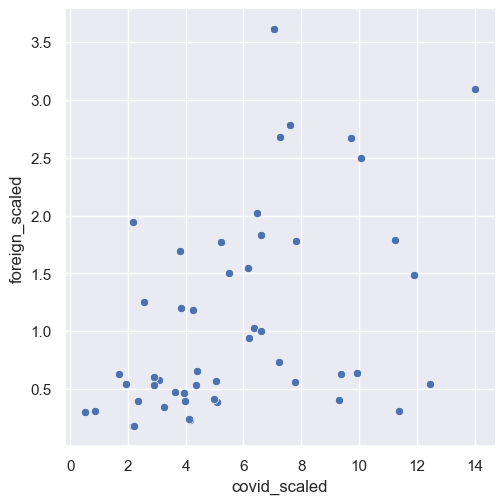

In [357]:
sns.set()
sns.relplot(x=df['covid_scaled'], y=df['foreign_scaled'])

<AxesSubplot:xlabel='covid_scaled', ylabel='income_scaled'>

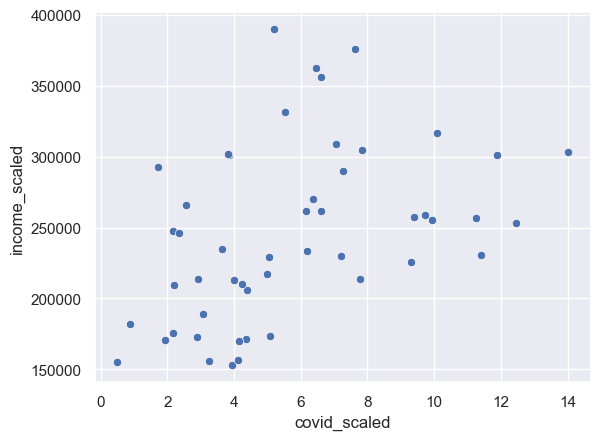

In [445]:
sns.scatterplot(data=df, x='covid_scaled', y='income_scaled')

<AxesSubplot:xlabel='covid_scaled', ylabel='grads_scaled'>

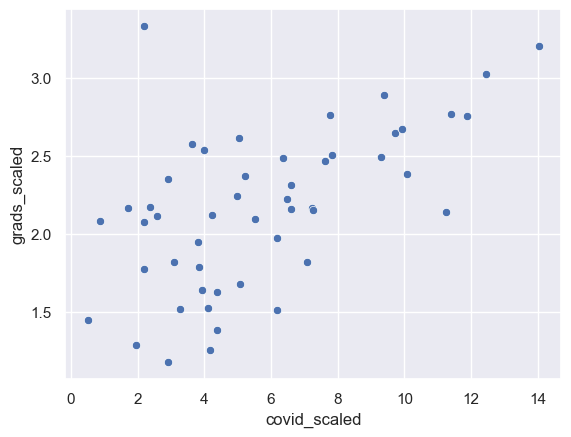

In [609]:
sns.scatterplot(data=df, x='covid_scaled', y='grads_scaled')

Like we saw with the choropleths, there seems to be a loose positive correlation between covid cases and high school grads, judging by the third plot. Furthermore, the other two plots display a very loose correlation, if any at all. However, there doesn't seem to be any other pattern than linear. This implies that during the machine learning phase, linear regression approaches might work well. 

<AxesSubplot:xlabel='covid_scaled', ylabel='median_age'>

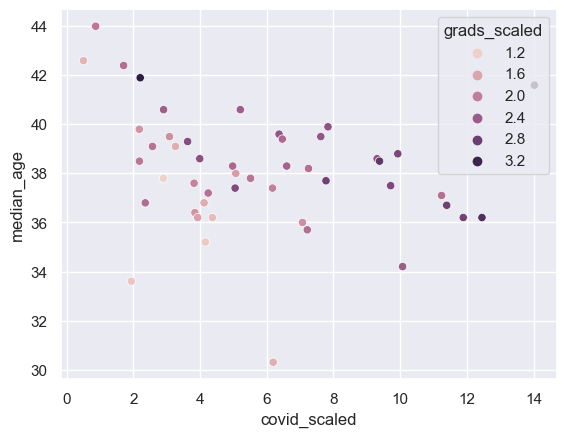

In [335]:
#Use a third variable to plot 
sns.scatterplot(data=df, x='covid_scaled', y='median_age', hue='grads_scaled', )

<AxesSubplot:xlabel='covid_scaled', ylabel='Unemployment'>

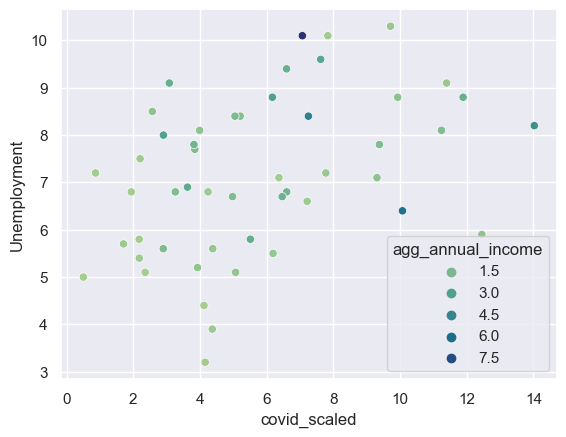

In [355]:
sns.scatterplot(data=df, x='covid_scaled', y='Unemployment', hue='agg_annual_income', palette='crest')

The plots with three variables also reveal some interesting characteristics. The points with higher annual income exist in the space with higher covid rates. Also, there is a strong negative linear correlation between median age and covid. Unemployment is  weak positive correlation at best, however. Looking at the visualizations it would make sense to do a more in depth analysis of the correlations before moving on. 

# Analyzing correlations and Hypothesis testing

Because we have so many potential features that could be used to predict covid positivity, it might be interesting to investigate the correlations between each one of those variables and our target variable. This insight could come in handy later when we do more in depth analysis with machine learning

We can start with a pairplot, which is useful to see relationships between all the features an the target. 
More details on seaborn's pairplot can be found here: https://indianaiproduction.com/seaborn-pairplot/  
For our uses, I just plotted the basic scatters and added a regression line.

Other examples of pairplots can be found in the graph gallery: https://python-graph-gallery.com/110-basic-correlation-matrix-with-seaborn/


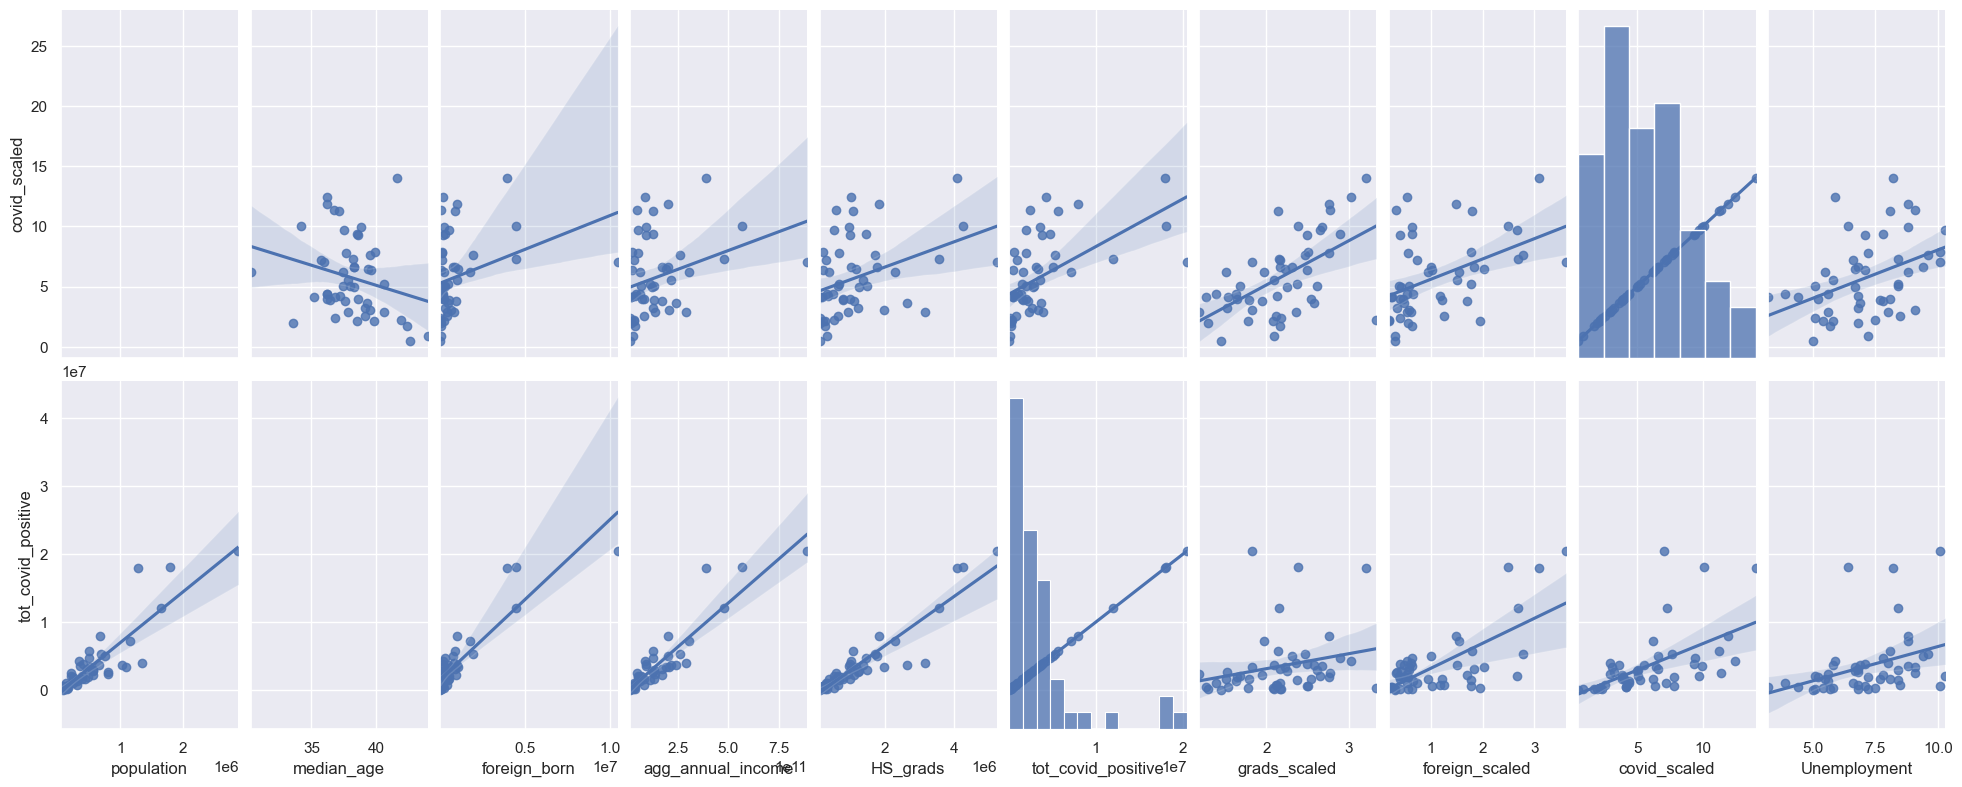

In [377]:
fig = sns.pairplot(df, kind='reg', y_vars=['covid_scaled', 'tot_covid_positive'], height=4, aspect=0.5)

Plotting against covid_scaled and total_covid clarifies that we should probably be using the scaled value from here on out. The total covid positivity shows higher visual correlations, but it is also clear that may only be because the points are all grouped so tightly in those graphs. Also, looking at the scatter plots in general, the scaled variables seem to be correlating better with the scaled covid counts than the raw values. This makes sense because the points are now closer in magnitude than their original counter parts. 

In terms of each individual relationship, it seems like grads_scaled, again, is showing some form of correlation. The unemployment value is also showing a promising graph. These may be variables we turn into features when doing regressions.

However, there are also some weakly correlated variables. For example, our previous scatter plots showed a potential negative correlation between median age and covid positivity. Here, there doesn't seem to be any relationship at all. Lastly, it wouldn't make sense to consider total covid cases as a predictor because it contains essentially the same information as covid_scaled, which would be cheating in our model. 

Let's generate more concrete correlation visualizations using a correlation heatmap. The plot would use pearson correlations and plot them in color so we can see which variables have the highest correlations with covid_scaled

In [425]:
def gen_heatmap(in_df):
    #generate correlations to plot
    var_corrs = in_df.corr()
    ret_val = sns.heatmap(var_corrs, 
                 cbar=True,
                # Include the values of the correlations in the plot
                 annot=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 yticklabels=var_corrs.columns,
                 xticklabels=var_corrs.columns)
    
    
    return ret_val

<AxesSubplot:>

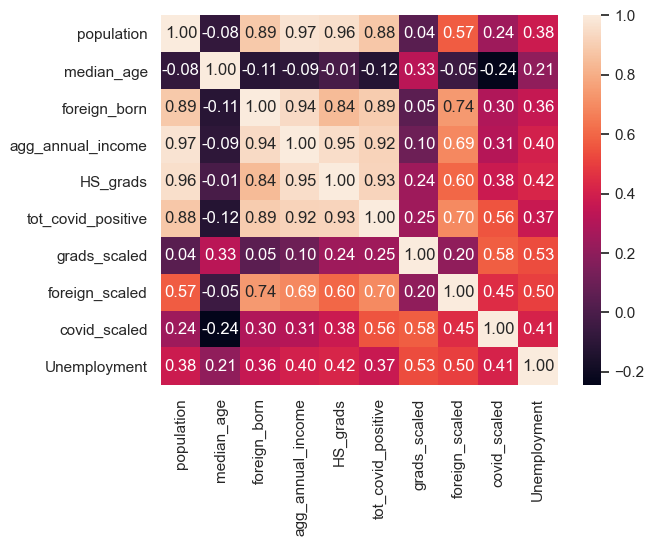

In [424]:
gen_heatmap(df)

When looking at the lightest portions of the graph, which represent the highest correlations, the unscaled variables and population all correlate very highly with each other. This makes sense because they would all increase as population increases, which is reflected in the choropleths we made earlier. Instead, we should pay attention to the row that contains correlations with covid_scaled. Judging by the values, grads_scaled, unemployment, and foreign born scaled all correlate decently with it. 

Furthermore, the value of -0.24 confirms our suspicions from the pairplot that median age probably isn't very correlated with covid positive cases. 
Careful not to be thrown off by the 1.0s across the diagonal of the matrix, this just means the variables correlate very highly with themselves. 
Extra reading on correlation matrices can be found here: https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Correlation_Matrix.pdf  
The above source does a great job of explaining the linear algebra and statistics behind generating the plot. 

Our plot only plots pearson correlations, however. There also exists another correlation coefficient that can propose another perspective on correlations between variables: the spearman correlation. The spearman correlation is less concerned on the values of the data, and it is more concerned with whether variables increase or decrease together. This source was great for getting a better understanding of the statistic: https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/  

Let's generate some correlation values.

In [459]:
#Time to start finding some correlations, spearmans, pearsons
correlations_df = pd.DataFrame(columns=['feature', 'pearson', 'pearson_p', 'spearman', 'spearman_p'])
for col in df.columns[2:]:
    #Generate the pearson correlations, and the related p value
    pearson, pearson_p = stats.pearsonr(df['covid_scaled'], df[col])
    #Generate the same for spearman
    spearman, spearman_p = stats.spearmanr(df['covid_scaled'], df[col])
    row = [col, pearson, pearson_p, spearman, spearman_p]
    correlations_df.loc[len(correlations_df)] = row

correlations_df

,feature,pearson,pearson_p,spearman,spearman_p
0,population,0.243445,0.088454,0.305642,3.088899e-02
1,median_age,-0.244553,0.086969,-0.277236,5.127566e-02
2,foreign_born,0.299724,0.034460,0.423193,2.198419e-03
3,agg_annual_income,0.311685,0.027566,0.392749,4.783672e-03
4,HS_grads,0.376033,0.007118,0.428283,1.916780e-03
5,tot_covid_positive,0.555776,0.000028,0.680192,5.530968e-08
6,grads_scaled,0.578410,0.000011,0.565042,1.911660e-05
7,foreign_scaled,0.448983,0.001074,0.486098,3.450890e-04
8,covid_scaled,1.000000,0.000000,1.000000,0.000000e+00
9,Unemployment,0.412018,0.002949,0.423382,2.187357e-03


In [460]:
#Sort the table by pearson correlation
correlations_df.sort_values(by='pearson', ascending=False)

,feature,pearson,pearson_p,spearman,spearman_p
8,covid_scaled,1.000000,0.000000,1.000000,0.000000e+00
6,grads_scaled,0.578410,0.000011,0.565042,1.911660e-05
5,tot_covid_positive,0.555776,0.000028,0.680192,5.530968e-08
7,foreign_scaled,0.448983,0.001074,0.486098,3.450890e-04
10,income_scaled,0.432497,0.001708,0.509916,1.552060e-04
9,Unemployment,0.412018,0.002949,0.423382,2.187357e-03
4,HS_grads,0.376033,0.007118,0.428283,1.916780e-03
3,agg_annual_income,0.311685,0.027566,0.392749,4.783672e-03
2,foreign_born,0.299724,0.034460,0.423193,2.198419e-03
0,population,0.243445,0.088454,0.305642,3.088899e-02


In [461]:
#sort the values by spearman correlations
correlations_df.sort_values(by='spearman', ascending=False)

,feature,pearson,pearson_p,spearman,spearman_p
8,covid_scaled,1.000000,0.000000,1.000000,0.000000e+00
5,tot_covid_positive,0.555776,0.000028,0.680192,5.530968e-08
6,grads_scaled,0.578410,0.000011,0.565042,1.911660e-05
10,income_scaled,0.432497,0.001708,0.509916,1.552060e-04
7,foreign_scaled,0.448983,0.001074,0.486098,3.450890e-04
4,HS_grads,0.376033,0.007118,0.428283,1.916780e-03
9,Unemployment,0.412018,0.002949,0.423382,2.187357e-03
2,foreign_born,0.299724,0.034460,0.423193,2.198419e-03
3,agg_annual_income,0.311685,0.027566,0.392749,4.783672e-03
0,population,0.243445,0.088454,0.305642,3.088899e-02


After looking at the sorted values, the same few variables keep rising to the top. However, even the variables with low correlations, the p value is relatively low, implying that the relationship is significantly different than 0. This means that even though the correlations are weak, the data isn't completely scattered and uncorrelated. 

So our hypothesis that some of these variable are correlated with covid_scaled seems to be valid. Let's see if we can use that relationship to make some predictions

# Predictions with Machine learning

Now that we'd like to move on to machine learning, one thing to consider is the number of features that we have. Currently, there are 9 features in our table, but we have already realized that only 7 of them are truly valuable. These means that we have a 7 dimensional feature space. We can reduce this feature space using a technique called PCA. PCA will transform our data into fewer dimensions while still explaining most of the data. 

Why don't we start by extracting out our features as numpy arrays that are easier to work with

In [581]:
#extract out the features and target val judging by our correlation table
vals = ['population','grads_scaled', 'income_scaled', 'foreign_scaled', 'Unemployment', 'median_age']
x = df[vals].values
y = df[['covid_scaled']].values

PCA is a technique that will essentially create new features that best encompass the feature space very well, but it will use fewer features to do it. This means it will reduce the dimensionality of our data, and really only consider combinations of the original features that contribute to variance in the data set.

While that explanation should be enough to understand the rest of the tutorial, it would be smart to read into PCA here: 
https://builtin.com/data-science/step-step-explanation-principal-component-analysis

We have to start by standardizing our inputs.

In [581]:
#Standardize the data for mean = 0 and var = 1
x = StandardScaler().fit_transform(x)
y = StandardScaler().fit_transform(y)

# Hyperparameter selection
Sklearn's PCA function takes a single hyperparameter that essentially represents how many features, or components, it will output. However, there aren't many ways to calculate the ideal number of components. Instead, I'll use a plot of explained variance ratio over the number of possible components. The explained variance ratio is a value that represents how much of the variance in the original dataset the components can represent. Ideally, you want this cummulative value to 1 when summed across all the components. 

Text(0, 0.5, 'cumulative explained variance')

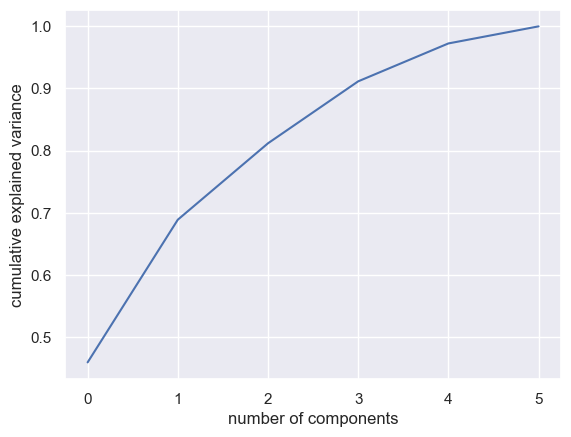

In [582]:
#Fit the model to the input variables
pca = PCA().fit(x)
#plot the evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

The plot reaches a value closest to 1 at 5 components, so unfortunately, the process of PCA wasn't able to reduce the dimensionality of our data too much. We essentially went from 7 features to 5 features, which is better than nothing. Now we know that the ideal number of components, or the dimension that we'd like to transform into, is 5. 

In [610]:
#Create the PCA with n_components = 5
pca = PCA(5)
pca.fit(x)

#Output the summed variance by each component, and also each individually
print(sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

0.9724900516416624
[0.45878105 0.22981712 0.12305439 0.0998013  0.06103619]


The components returned by the PCA calculation gave a set that could capture 0.97 of the variation of the dataset, which is pretty good for our standards. 
Furthermore, it is clear that the last two components were contributing less and less to the information in the dataset.

Let's use the computed features to perform a linear regression and test if they have any prediction power. 

In [589]:
#Get the components
data = pca.transform(x)
#create a dataframe containing the input and target variable
pca_df = pd.DataFrame(data=data, columns=['c1', 'c2', 'c3', 'c4', 'c5'])
target_df = pd.DataFrame(data=y, columns=['target'])
pca_df = pd.concat([pca_df, target_df], axis=1)

In [590]:
#What the assembled data frame looks like
pca_df.head()

,c1,c2,c3,c4,c5,target
0,-0.392448,-0.852019,-0.041533,-0.498020,0.324274,1.108975
1,-2.164217,1.537582,-0.564755,-0.719068,-1.152537,-1.188094
2,0.699992,0.450738,-0.316677,-0.075277,-0.517736,1.711811
3,-0.330352,-0.963079,-0.516800,-0.896425,0.428160,0.631133
4,4.082276,3.570861,2.068061,-0.476739,0.113019,0.411396


# Linear Regression

The regression we are going to compute is technically a multiple regression because we are using more than one input variable. However, the value of each input variable will hold a linear relationship to the target, instead of a polynomial regression where the degree could be higher. 

We should proceed with a linear regression because many of our original features seemed to have decent linear correlations with the target variable, covid_scaled. Let's create the model. You'll notice, however, that I don't fit the model just yet. 

In [614]:
lm = linear_model.LinearRegression()

Instead of running a linear regression like normal and creating predictions, I will use a Kfold cross validation to figure out how well our linear regression model is performing. The technique will split our data into training and testing segments, which it will use to generate a score for our model. The scores will be in the form of R-squared values. 

The code below splits the code 5 times 5 different ways, runs the validation, and then outputs the results of all 5 splits. We only need 5 splits because there aren't many datapoints in our dataset to warrant more folds. 

For more information of Kfold validation, feel free to check this link, which has a more in depth view of how the process works: https://machinelearningmastery.com/k-fold-cross-validation/

In [613]:
#Create the folds to perform. Inclue shuffle=True to shuffle the dataset for each split. 
#Random state is a seed to handle that shuffle, really just creates reproducability
folds = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = model_selection.cross_val_score(lm, pca_df.iloc[:, :5], pca_df[['target']], scoring='r2', cv=folds)
scores

array([0.07481582, 0.60392998, 0.75425114, 0.1930851 , 0.01981472])

The highest r-squared values achieved were 0.6 and 0.75, which implies that the model is performing well. However, it isn't reassuring that there are some very low values as well. So the model is decent at predicting covid positivity rates given the rest of our inputs. 

So turns out there was some prediction power in the variables that we chose and the resulting PCA components we generated. Part of the reason it might not have performed perfectly is because Covid19 positivity rates are likely a far more complex value than just a linear combination of 7 features. 

# Conclusion and Insight

The tutorial hopefully taught you a decent amount about data science techniques like querying an API, tidying data, creating visualizations, PCA, and linear regressions.
However, through the tutorial, we also revealed a good amount of insight into the data set and COVID19 in general. 

The set of variables we chose showed actual prediction power in predicting covid19 rates of a state. This implies that chances are, our variables affect, or are affected by, the rate of covid positive cases. This leads to some interesting conclusions:

1. Judging by our correlations and correlation table, Unemployment correlated relatively well with covid19 rates. At first glance this might imply that unemployed people are more likely to test positive. However, it makes more sense that states that have high numbers of positive tests are struggling economically by shutting down and that people are losing their jobs as a result. 

2. The number of foreign born residents and the number of residents with only a high school degree consistently correlated very well with covid19 rates. This implies that places that have a high number of uneducated people or immigrants or both could be more susceptible to COVID19. Chances are they don't have the resources to handle an outbreak.

3. The fact that our model didn't perform very well implies that covid19 is a much more complex issue than just a small set of census variables. There may be other variables, that don't have linear relationships with covid positivity rates, that could improve predictions. 

As covid19 has taken over our lives, I hope this tutorial presented ideas and insights that could help better understand how our communities are affected by the virus. The results of the tutorial show that we should be paying special care to immigrant, unemployed, and under educated groups in the united states. The tutorial also shows, glaringly, that much more research is necessary. 

In [615]:
# https://sakshumkulshrestha.github.io/sakshumkulshrestha.github.io/